In [1]:
!pip install -q kaggle
import json

data = {"username":"tunkedsaro","key":"ff3d00dc680ff94caf6f8d4d9bcd3168"}
json_data = json.dumps(data)

# Write the JSON string to a file
file_path = "/content/kaggle.json"
with open(file_path, 'w') as json_file:
    json_file.write(json_data)

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ #copy api key ---- depend on your directory -- my directory is .../colab/..
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c brain-motor-imagery-classification

ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                          Netflix Movies and TV Shows                        1MB  2024-04-10 09:48:38          18578        406  1.0              
ashishkumarak/netflix-reviews-playstore-daily-updated           Netflix Reviews [DAILY UPDATED]                   12MB  2024-05-14 23:37:32            855         29  1.0              
sahirmaharajj/school-student-daily-attendance                   School Student Daily Attendance                    2MB  2024-04-29 19:29:56           4347         90  1.0              
sahirmaharajj/college-exam-results-sat                          College Exa

In [2]:
!unzip /content/brain-motor-imagery-classification.zip

Archive:  /content/brain-motor-imagery-classification.zip
  inflating: sample_submission.csv   
  inflating: test/00edaaa8-102d-4ee3-b531-0be67dcbd9e6.npy  
  inflating: test/01b63df8-05f9-4956-87f4-949ed9ae4dd6.npy  
  inflating: test/01bfd881-7850-49f1-ad32-ff9ae51e3e3f.npy  
  inflating: test/01d9002f-b086-4635-bf74-5316ceda3098.npy  
  inflating: test/028522a4-5332-4e84-b578-ce45ed5e4899.npy  
  inflating: test/0368a7cc-d6c6-416d-878e-edbcd562f317.npy  
  inflating: test/044841bc-050d-4c9f-92db-1ff1a7f306cb.npy  
  inflating: test/051581bf-c779-4d9c-86e9-324404b149ca.npy  
  inflating: test/06360991-5140-41a1-889f-3cb10b2241d0.npy  
  inflating: test/066dc317-8b3c-431e-b5d9-894abe3a4857.npy  
  inflating: test/06e9b7ab-0ee9-47a3-a500-a8dab4ee097f.npy  
  inflating: test/06f9ab25-f9b7-4a12-82f3-a3c92adcc645.npy  
  inflating: test/072dc9a9-7bfa-4da9-83d7-23b2ed5818e0.npy  
  inflating: test/075e9017-dace-441d-acbd-dd929c1a06f7.npy  
  inflating: test/0783e1ea-375e-4239-be7d-12177a54

<hr>

In [3]:
from scipy.signal import butter, filtfilt, iirnotch, freqz
import os
import numpy as np

In [4]:
# Band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Notch filter
def notch_filter(data, cut_freq, fs, Q=30):
    nyq = 0.5 * fs
    freq = cut_freq / nyq
    b, a = iirnotch(freq, Q)
    y = filtfilt(b, a, data)
    return y

def filter03050(Ipsignal):
    sampling_rate = 250  # Hz
    # fft_signal = np.fft.fft(Ipsignal)
    # frequencies = np.fft.fftfreq(len(Ipsignal), 1/sampling_rate)
    filtered_signal = bandpass_filter(Ipsignal, 1, 30, sampling_rate)          # band-pass filter 0-30 Hz
    filtered_signal = notch_filter(filtered_signal, 50, sampling_rate)       # notch filter 50 Hz
    return filtered_signal

def unique_name(Datapath):
    all_name = os.listdir(Datapath)
    new = []
    for un in all_name:
        i = un.replace("_data_time_series.npy","").replace("_data_time_stamps.npy","").replace("_label_time_series.npy","").replace("_label_time_stamps.npy","")
        new.append(i)
        unique_name = list(set(new))
    return unique_name

def check_different_duration(label_time_stamps):
    keep_time = []
    start_time = 0
    for current_time in list(label_time_stamps):
        keep_time.append(current_time-start_time)
        start_time = current_time
    keep_time = keep_time[1:]
    avgtime = sum(keep_time)/len(keep_time)
    stat = True
    for etime in keep_time:
        if 6.8 <= etime <= 7.5:
            stat = True
        else:
            stat = False
            break
    return stat,avgtime

file_path = "/content/train/train"
unique_name = unique_name(file_path)

In [5]:
unique_name.remove("s1_d2_p002_003")          # sameple ห่าง
unique_name.remove("s1_d2_p006_008")          # label != 30
unique_name.remove("s2_d2_p002_006")          # label != 30

In [6]:
data_dataset  = []
label_dataset = []
for name in unique_name:
    # print(name)
    signals           = np.load(os.path.join(file_path,name+"_data_time_series.npy"))
    times             = np.load(os.path.join(file_path,name+"_data_time_stamps.npy"))
    label_time_series = np.load(os.path.join(file_path,name+"_label_time_series.npy"))
    label_time_stamps = np.load(os.path.join(file_path,name+"_label_time_stamps.npy"))
    signals = signals[:,:8]
    stat,avgtime = check_different_duration(label_time_stamps)
    if not(stat):
        continue
    # print("Avg time",self.avgtime)
    if filter!=None:
        filtered_signal = []
        Dim = signals.shape[1]
        # print(Dim)
        for i in range(Dim):
            # print(f"{i} : {signals[:,i]}")
            filtered_signal.append(filter03050(signals[:,i]))
        signals = np.array(filtered_signal).T
    sample_point = int(round(avgtime))
    datapoint = 250 * sample_point                   # 250 Hz * 7 s
    for index in range(30):
        # start_point = index * datapoint
        # end_point = (index + 1) * datapoint
        # if end_point <= signals.shape[0]:  # Check to ensure slice is within the data range
        #     data_dataset.append(signals[start_point:end_point])
        # else:
        #     break
        sn = signals[1750*i:1750*(i+1)]
        if sn.shape[0]!=30 and sn.shape[1]!=8:
            print(name,"error")
        data_dataset.append(sn)
    label_dataset.append(label_time_series)

data_dataset = np.stack(data_dataset)

label_dataset = np.concatenate(label_dataset)
label_dataset = label_dataset.flatten().tolist()
# print(data_dataset)
# print(label_dataset)
# data_sliced_with_label = tuple(zip(data_dataset,label_dataset))

In [7]:
# Demension check
data_dataset.shape

(5640, 1750, 8)

In [8]:
label_dataset = np.array(label_dataset)
label_dataset

array([120, 110, 150, ..., 150, 120, 110])

In [9]:
label_dataset.shape

(5640,)

<hr>

<h1>Train model</h1>

In [10]:
pip install braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

In [11]:
from braindecode.models.util import models_dict
print(f'All the Braindecode models:\n{list(models_dict.keys())}')

All the Braindecode models:
['ATCNet', 'Deep4Net', 'DeepSleepNet', 'EEGConformer', 'EEGITNet', 'EEGInception', 'EEGInceptionERP', 'EEGInceptionMI', 'EEGNetv1', 'EEGNetv4', 'EEGResNet', 'HybridNet', 'ShallowFBCSPNet', 'SleepStagerBlanco2020', 'SleepStagerChambon2018', 'SleepStagerEldele2021', 'TCN', 'TIDNet', 'USleep']


In [12]:
from braindecode.models import ShallowFBCSPNet              # Import the model from braindecode * There are many model that available
import mne
import numpy as np

In [13]:
# Train spect config
model = ShallowFBCSPNet(
    n_chans   = 8,
    n_times   = 1750,
    n_outputs = 3,
    final_conv_length='auto',
)
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 8, 1750]              [1, 3]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 8, 1750]              [1, 8, 1750, 1]           --                        --
├─Rearrange (dimshuffle): 1-2            [1, 8, 1750, 1]           [1, 1, 1750, 8]           --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1750, 8]           [1, 40, 1726, 1]          13,840                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 1726, 1]          [1, 40, 1726, 1]          80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 1726, 1]          [1, 40, 1726, 1]          --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 1726, 1]          [1, 40, 111, 1]           --                        [75, 1]
├─Express

/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


<li>Dimension checker before train</li>

In [14]:
data_dataset = data_dataset.reshape(5640, 8, 1750)
data_dataset.shape

(5640, 8, 1750)

In [15]:
label_dataset.shape

(5640,)

In [16]:
label_dataset = np.array(label_dataset)
label_dataset

array([120, 110, 150, ..., 150, 120, 110])

In [17]:
# Map value
mapping = {110: 0,
           120: 1,
           150: 2}

mapped_label = np.vectorize(mapping.get)(label_dataset)
label = np.array(mapped_label)
label

array([1, 0, 2, ..., 2, 1, 0])

In [18]:
info = mne.create_info(
    ch_names = ['c1','c2','c3','c4','c5','c6','c7','c8'], sfreq=250., ch_types="eeg"
)
# data_dataset  # 100 epochs, 8 channels, 7 seconds (@250Hz)
epochs = mne.EpochsArray(data_dataset, info=info)


Not setting metadata
5640 matching events found
No baseline correction applied
0 projection items activated


In [19]:
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier

In [20]:
net = EEGClassifier(
    'ShallowFBCSPNet',
    module__final_conv_length='auto',
    max_epochs=3,
    train_split=ValidSplit(0.2),
    # To train a neural network you need validation split, here, we use 20%.
)
# Train model
net.fit(epochs, label)

/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1       63.0297       0.3378       21.1369  90.6221
      2       15.1869       0.3165       16.1790  77.6279
      3        6.4328       0.3041        6.0710  77.1159


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 8, 1750]              [1, 3]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 8, 1750]              [1, 8, 1750, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 8, 1750, 1]           [1, 1, 1750, 8]           --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1750, 8]           [1, 40, 1726, 1]          13,840                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 1726, 1]          [1, 40, 1726, 1]          80                        --
  ├─Expression (conv_nonlin_exp): 

<hr>

<h1>Test model</h1>

In [21]:
from scipy.signal import butter, filtfilt, iirnotch, freqz
import os

In [22]:
data_dataset  = []
label_dataset = []
file_path = "/content/train/train"
unique_name = ["s1_d2_p002_002"]
for name in unique_name:
    print(name)
    signals           = np.load(os.path.join(file_path,name+"_data_time_series.npy"))
    times             = np.load(os.path.join(file_path,name+"_data_time_stamps.npy"))
    label_time_series = np.load(os.path.join(file_path,name+"_label_time_series.npy"))
    label_time_stamps = np.load(os.path.join(file_path,name+"_label_time_stamps.npy"))
    signals = signals[:,:8]
    print(signals.shape)
    stat,avgtime = check_different_duration(label_time_stamps)
    if not(stat):
        continue
    # print("Avg time",self.avgtime)
    if filter!=None:
        filtered_signal = []
        Dim = signals.shape[1]
        print(Dim)
        for i in range(Dim):
            # print(f"{i} : {signals[:,i]}")
            filtered_signal.append(filter03050(signals[:,i]))
        signals = np.array(filtered_signal).T
    sample_point = int(round(avgtime))
    datapoint = 250 * sample_point                   # 250 Hz * 7 s
    for index in range(30):
        start_point = index * datapoint
        end_point = (index + 1) * datapoint
        if end_point <= signals.shape[0]:  # Check to ensure slice is within the data range
            data_dataset.append(signals[start_point:end_point])
        else:
            break
    label_dataset.append(label_time_series)
data_dataset = np.stack(data_dataset)
print(data_dataset.shape)
label_dataset = np.concatenate(label_dataset)
label_dataset = label_dataset.flatten().tolist()

s1_d2_p002_002
(53714, 8)
8
(30, 1750, 8)


In [23]:
data_dataset = data_dataset.reshape(30,8,1750)
data_dataset.shape

(30, 8, 1750)

In [24]:
test_epochs = mne.EpochsArray(data_dataset,info=info)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


In [25]:
# Get predictions from the trained model
predictions = net.predict(test_epochs)
probabilities = net.predict_proba(test_epochs)

In [26]:
# Map value
mapping = {110: 0, 120: 1, 150: 2}

mapped_label = np.vectorize(mapping.get)(label_dataset)
print(mapped_label)

[1 0 2 2 1 0 1 0 2 2 1 0 1 2 0 2 1 0 1 0 2 2 1 0 2 1 0 2 1 0]


In [27]:
print("Predictions:", predictions)
print("Probabilities:", probabilities)

Predictions: [2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 2 1 2 2 2 1 2 2 0 0 2]
Probabilities: [[3.65208507e-01 7.70806074e-02 5.57710826e-01]
 [6.26833178e-03 4.08300461e-04 9.93323386e-01]
 [4.16387618e-01 4.93399471e-01 9.02129784e-02]
 [1.22390296e-02 1.77659276e-05 9.87743258e-01]
 [8.57178587e-03 1.32937939e-03 9.90098774e-01]
 [5.40829904e-04 3.03833094e-05 9.99428809e-01]
 [5.08825528e-03 7.58165479e-05 9.94835973e-01]
 [2.88890228e-02 1.03094289e-02 9.60801482e-01]
 [2.91758945e-04 3.24516982e-08 9.99708235e-01]
 [4.53359745e-02 1.52219515e-02 9.39442098e-01]
 [9.81539756e-08 1.17501411e-10 9.99999881e-01]
 [4.05803090e-03 9.77423952e-07 9.95941043e-01]
 [3.80242855e-05 4.25396956e-06 9.99957681e-01]
 [7.12206092e-05 3.58417594e-07 9.99928474e-01]
 [1.17431104e-03 3.68874083e-07 9.98825252e-01]
 [2.11324692e-02 5.82881000e-07 9.78866994e-01]
 [1.14580430e-03 3.41809136e-05 9.98820007e-01]
 [1.26167061e-02 5.56177139e-01 4.31206197e-01]
 [8.89145374e-01 1.63878426e-02 9.44668204e-02

In [28]:
Cm = 0
for i,j in zip(mapped_label,predictions):
    print(i,j,i==j)
    if i==j:
        Cm+=1
print(f"{Cm}/{len(predictions)}")

1 2 False
0 2 False
2 1 False
2 2 True
1 2 False
0 2 False
1 2 False
0 2 False
2 2 True
2 2 True
1 2 False
0 2 False
1 2 False
2 2 True
0 2 False
2 2 True
1 2 False
0 1 False
1 0 False
0 2 False
2 1 False
2 2 True
1 2 False
0 2 False
2 1 False
1 2 False
0 2 False
2 0 False
1 0 False
0 2 False
6/30


<hr>

<h1>Prediction</h1>


In [29]:
import pandas as pd

In [87]:
sample_submission = pd.read_csv("/content/sample_submission.csv")
sample_submission

,id,predict
0,a0dfb1f6-a76b-404f-a04a-b61e955ce1ef,110.0
1,51afd110-7556-4a7d-b6d2-68e46256f267,150.0
2,eb229854-1a14-4e1f-8e52-470edbec47c9,150.0
3,8fa74efe-f269-415e-a968-1a92e7c66fe6,NaN
4,7b209881-a1dd-4aa3-a06a-037908b07bfa,NaN
...,...,...
475,69e84db3-0019-4e38-90fc-968f45747a16,NaN
476,d18d7d80-78fa-402a-ba1c-e35d72382b18,NaN
477,0a532391-dd42-413f-ab15-798960de95d6,NaN
478,0c02ad4f-de15-48cb-ad31-0925e69bfe97,NaN


In [88]:
test_file_path = '/content/test'
for ss in sample_submission["id"][3:]:
    file_name = os.path.join(test_file_path,ss+".npy")
    signals   = np.load(file_name)[:,:8]
    filtered_signal = []
    Dim = signals.shape[1]
    for i in range(Dim):
        filtered_signal.append(filter03050(signals[:,i]))
    signals = np.array(filtered_signal).T
    signals_reshape = signals.T.reshape(1, 8, signals.shape[0])

    test_epochs = mne.EpochsArray(signals_reshape,info=info)
    predictions = net.predict(test_epochs)
    sample_submission.loc[sample_submission['id'] == ss, 'predict'] = predictions[0]

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

In [97]:
sample_submission['predict'] = sample_submission['predict'].apply(lambda ip: "110" if ip == 0 else "120" if ip == 1 else "150" if ip == 2 else str(int(ip)))

In [98]:
sample_submission

,id,predict
0,a0dfb1f6-a76b-404f-a04a-b61e955ce1ef,110
1,51afd110-7556-4a7d-b6d2-68e46256f267,150
2,eb229854-1a14-4e1f-8e52-470edbec47c9,150
3,8fa74efe-f269-415e-a968-1a92e7c66fe6,120
4,7b209881-a1dd-4aa3-a06a-037908b07bfa,120
...,...,...
475,69e84db3-0019-4e38-90fc-968f45747a16,120
476,d18d7d80-78fa-402a-ba1c-e35d72382b18,120
477,0a532391-dd42-413f-ab15-798960de95d6,120
478,0c02ad4f-de15-48cb-ad31-0925e69bfe97,120


In [105]:
import matplotlib.pyplot as plt

In [102]:
i110 = 0
i120 = 0
i150 = 0
for item in list(sample_submission['predict']):
    if item == '110':
        i110+=1
    elif item == '120':
        i120+=1
    elif item == '150':
        i150+=1

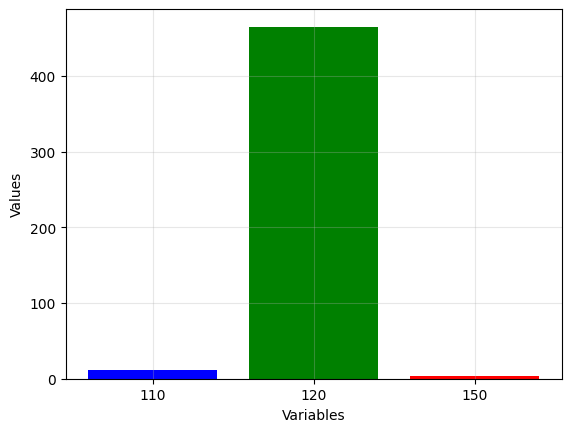

In [110]:
# Labels and values for the bar plot
labels = ['110', '120', '150']
values = [i110, i120, i150]

# Create the bar plot
plt.bar(labels, values, color=['blue', 'green', 'red'])

# Add title and labels to the plot
plt.xlabel('Variables')
plt.ylabel('Values')
plt.grid(alpha=0.3)

# Display the plot
plt.show()

In [99]:
sample_submission.to_csv("/content/brainwave 0.1.4.csv", index=False)

In [ ]:
EEGModuleMixi
ShallowFBCSPNe
Deep4Ne
DeepSleepNe
EEGConforme
EEGInceptio
EEGInceptionER
EEGInceptionM
ATCNe
EEGITNe
EEGNetv
EEGNetv
HybridNe
EEGResNe
TC
SleepStagerChambon201
SleepStagerBlanco202
SleepStagerEldele202
USlee
TIDNet